In [2]:
import torch 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# import xResNet as m
import Inception1d as m
import Preprocessing as P
from tqdm import tqdm

#hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "First-edition\\"
sampling_rate = 100
num_eporch = 10
thresh_hold = 0.5

#network
net = m.inception1d().float()
# net = m.xresnet1d50_deeper().float() #could be other types of xresnet, see xResNet.py for more info


criterion = nn.functional.binary_cross_entropy_with_logits
optimizer = optim.Adam(net.parameters(), lr=0.001)

#data
data = P.Preprocessing(path,sampling_rate,experiment="diagnostic_superclass")

X = data.get_data_x()
x_train = np.concatenate((X[0][0],X[0][1],X[0][2]),axis = 1)
x_train = torch.from_numpy(x_train)

x_val = np.concatenate((X[1][0],X[1][1],X[1][2]),axis = 1)
x_val = torch.from_numpy(x_val)

x_test = np.concatenate((X[2][0],X[2][1],X[2][2]),axis = 1)
x_test = torch.from_numpy(x_test)

Y = data.get_data_y()
y_train = torch.from_numpy(Y[0])
y_val = torch.from_numpy(Y[1])
y_test = torch.from_numpy(Y[2])


Sle = data.get_data_metadata()

#dataloader
train_data = DataLoader(TensorDataset(x_train,y_train), batch_size=32, shuffle=True)

val_data = DataLoader(TensorDataset(x_val,y_val), batch_size = 32, shuffle=False)

test_data = DataLoader(TensorDataset(x_test,y_test), batch_size = 32, shuffle=False)


In [3]:
# import xResNet as m
# net = m.xresnet1d50_deeper().float()
#with inception, it takes 3 minutes to finish an epoch on my lovely thingy
net.to(device)
#storing stuff for matplotlib
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []

for epoch in tqdm(range(num_eporch)):
    net.train()
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    print("Epoch {}:/n-----------------------------------------------------------".format(epoch +1)) 
    
    for inputs, labels in tqdm(train_data):
        inputs, labels = inputs.to(device),labels.to(device)
        running_loss = 0.0
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.float())
        outputs.to(device)
        loss = criterion(outputs, (labels.float()))
        loss.backward()
        optimizer.step()
        
        pred = outputs.cpu().detach().numpy() > thresh_hold
        acc = (pred == labels.cpu().detach().numpy()).sum()/(inputs.shape[0]*5)
        
        running_loss += loss.item()
        train_loss.append(loss.item())
        train_acc.append(acc)
        # print("epoch{}: loss per batch:{:.4f}".format(epoch+1, running_loss))
        # print("Accuracy of epoch{} per batch:{}".format(epoch+1, acc*100))
        # the above two lines are for those who want to burn your own eyes
    print("========================================================")
    epoch_train_acc.append(sum(train_acc)/len(train_acc))
    epoch_train_loss.append(sum(train_loss)/len(train_loss))
    print("Train loss of epoch {}:{:.4f}".format(epoch+1, epoch_train_loss[-1]))    
    print("Train accuracy of epoch {}:{:}".format(epoch+1, epoch_train_acc[-1]))

    with torch.no_grad():
        net.eval()
        running_loss = 0.0
        batch_val = []
        for inputs, labels in tqdm(val_data):
            inputs, labels = inputs.cuda(),labels.cuda()
            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels.float())
            
            pred = outputs.cpu().detach().numpy() > thresh_hold
            acc = (pred == labels.cpu().detach().numpy()).sum()/(inputs.shape[0]*5)
            batch_val.append(acc)
            running_loss += loss.item()
            val_loss.append(loss.item())
            val_acc.append(acc)
    epoch_val_loss.append(sum(val_loss)/len(val_loss))
    epoch_val_acc.append(sum(val_acc)/len(val_acc))
    print("========================================================")
    print("Validation loss of epoch {}:{:.4f}".format(epoch+1, epoch_val_loss[-1]))    
    print("Validation accuracy of epoch {}:{:}".format(epoch+1, epoch_val_acc[-1]))

print("\nfinished training =================================================")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:35<00:00,  3.50it/s]


Train loss of epoch 1:0.5520
Train accuracy of epoch 1:0.7443417431192664


 10%|█         | 1/10 [02:40<24:03, 160.39s/it]

Validation loss of epoch 1:0.5407
Validation accuracy of epoch 1:0.7457039337474121
Epoch 2:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:27<00:00,  3.68it/s]


Train loss of epoch 2:0.5359
Train accuracy of epoch 2:0.745353211009174


 20%|██        | 2/10 [05:13<20:46, 155.87s/it]

Validation loss of epoch 2:0.5621
Validation accuracy of epoch 2:0.7457039337474118
Epoch 3:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:18<00:00,  3.94it/s]


Train loss of epoch 3:0.4424
Train accuracy of epoch 3:0.7929747706422025


 30%|███       | 3/10 [07:36<17:30, 150.02s/it]

Validation loss of epoch 3:0.4618
Validation accuracy of epoch 3:0.760973084886128
Epoch 4:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:25<00:00,  3.74it/s]


Train loss of epoch 4:0.3714
Train accuracy of epoch 4:0.8353646788990828


 40%|████      | 4/10 [10:06<15:01, 150.18s/it]

Validation loss of epoch 4:0.3778
Validation accuracy of epoch 4:0.8244694616977225
Epoch 5:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:23<00:00,  3.79it/s]


Train loss of epoch 5:0.3490
Train accuracy of epoch 5:0.8471926605504585


 50%|█████     | 5/10 [12:34<12:27, 149.51s/it]

Validation loss of epoch 5:0.3707
Validation accuracy of epoch 5:0.8411361283643893
Epoch 6:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:23<00:00,  3.80it/s]


Train loss of epoch 6:0.3375
Train accuracy of epoch 6:0.8536032110091746


 60%|██████    | 6/10 [15:03<09:56, 149.23s/it]

Validation loss of epoch 6:0.3722
Validation accuracy of epoch 6:0.8379270186335407
Epoch 7:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:24<00:00,  3.76it/s]


Train loss of epoch 7:0.3283
Train accuracy of epoch 7:0.8580344036697242


 70%|███████   | 7/10 [17:32<07:27, 149.29s/it]

Validation loss of epoch 7:0.3444
Validation accuracy of epoch 7:0.8469849896480334
Epoch 8:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:19<00:00,  3.90it/s]


Train loss of epoch 8:0.3216
Train accuracy of epoch 8:0.8621582568807337


 80%|████████  | 8/10 [19:57<04:55, 147.77s/it]

Validation loss of epoch 8:0.3483
Validation accuracy of epoch 8:0.8528209109730851
Epoch 9:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:34<00:00,  3.52it/s]


Train loss of epoch 9:0.3166
Train accuracy of epoch 9:0.8638853211009169


 90%|█████████ | 9/10 [22:36<02:31, 151.40s/it]

Validation loss of epoch 9:0.3466
Validation accuracy of epoch 9:0.8492883022774327
Epoch 10:/n-----------------------------------------------------------


100%|██████████| 545/545 [02:59<00:00,  3.04it/s]


Train loss of epoch 10:0.3108
Train accuracy of epoch 10:0.8666926605504587


100%|██████████| 10/10 [25:40<00:00, 154.08s/it]

Validation loss of epoch 10:0.3440
Validation accuracy of epoch 10:0.8462474120082818

finished training =================================================


In [4]:
#here should lie the testing code
test_loss = []
test_acc = []
with torch.no_grad():
    net.eval()
    running_loss = 0.0
    batch_test = []
    for inputs, labels in tqdm(test_data):
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = net(inputs.float())
        outputs.to(device)
        loss = criterion(outputs, labels.float())
        pred = outputs.cpu().detach().numpy() > thresh_hold
        acc = (pred == labels.cpu().detach().numpy()).sum()/(inputs.shape[0]*5)
        batch_test.append(acc)
        running_loss += loss.item()
        test_loss.append(loss.item())
        test_acc.append(acc)
print("========================================================")
print("Test loss:{:.4f}".format(sum(test_loss)/len(test_loss)))    
print("Test accuracy:{:}".format(sum(batch_test)/len(batch_test)))

100%|██████████| 69/69 [00:04<00:00, 14.09it/s]

Test loss:0.3436
Test accuracy:0.8517704216073781


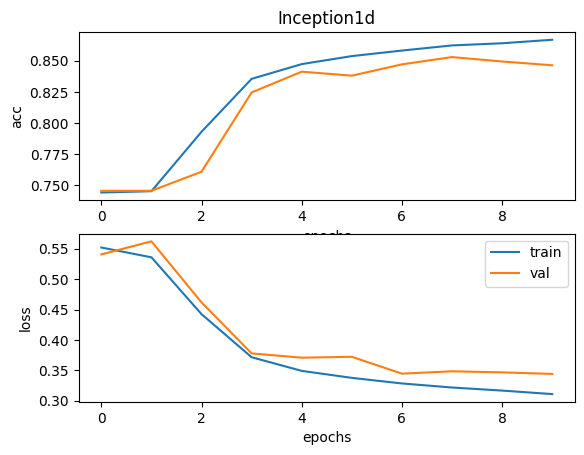

In [18]:
import matplotlib.pyplot as plt
#visualize
figure, axis = plt.subplots(2)
#accuracy plot
axis[0].set_title('Inception1d')
axis[0].plot(epoch_train_acc,label='train_acc')
axis[0].plot(epoch_val_acc,label='val_acc')
axis[0].set_xlabel('epochs')
axis[0].set_ylabel('acc')


axis[1].plot(epoch_train_loss,label='train')
axis[1].plot(epoch_val_loss,label='val')
axis[1].set_xlabel('epochs')
axis[1].set_ylabel('loss')

plt.savefig("Inception1d.jpg")
plt.legend()
plt.show()